# Homework 1 - KNN
## CSCI 5622 - Spring 2019

For today's assignment, we will be implementing our own K-Nearest Neighbors (KNN) algorithm.

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But 1) I'll know that you know what's really going on, and 2) you'll know you can do it, because 2a) someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...), or maybe because you're working on something important and you need to control exactly what's on there (should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split
import pandas as pd
from prettytable import PrettyTable #pip install PrettyTable

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*

Yes - but it also has a ton of helper functions, including a dataset we'll be using later. But, for now, let's set up a KNNClassifier class.

In [2]:
import sklearn.neighbors

class KNNClassifier:
    
    def __init__(self, X, y, k = 5):
        """
        Initialize our custom KNN classifier
        PARAMETERS
        X - our training data features
        y - our training data answers
        k - the number of nearest neighbors to consider for classification
        """
        self._model = sklearn.neighbors.BallTree(X)
        self._y = y[0]
        if len(y.shape) == 1:
            self._y = y
        self._k = k
        self._counts = self.getCounts()
        self._errors = {}
        
    def getCounts(self):
        """
        Creates a dictionary storing the counts of each answer class found in y
        RETURNS
        counts - a dictionary of counts of answer classes
        """
        counts = dict(pd.Series(self._y).value_counts())
        return(counts)
    
    def majority(self, indices):
        """
        Given indices, report the majority label of those points.
        For a tie, report the most common label in the data set.
        PARAMETERS
        indices - an np.array, where each element is an index of a neighbor
        RETURNS
        label - the majority label of our neighbors
        """
        label = 0
        counts = {}
        
        #calculate counts for each label
        for i in indices[0]:
            counts[self._y[i]] = counts.get(self._y[i], 0) + 1
        
        #determine the majority label
        max_keys = [k for k, v in counts.items() if v == max(counts.values())]
        if len(max_keys) == 1:
            label = max_keys[0]
        else:
            tot_counts = self.getCounts()
            sub_counts = {k: tot_counts[k] for k in max_keys}
            label = max(sub_counts, key=sub_counts.get)
            
        return(label)
    
    def classify(self, point):
        """
        Given a new data point, classify it according to the training data X and our number of neighbors k into the appropriate class in our training answers y
        PARAMETERS
        point - a feature vector of our test point
        RETURNS
        ans - our predicted classification
        """
        ans = 0
        dist, ind = self._model.query(np.array(list([point])), k=self._k)
        ans = self.majority(ind)

        return(ans)
    
    def getIndices(self):
        '''
        Return a dict with key=class and it's index in the
        confusion matrix(value)
        '''
        counts = self.getCounts()
        n = len(counts)
        indices = {}
        for i, j in zip(counts.keys(), range(n)):
            indices[i] = j
        
        return indices
        
    def store_errors(self, index, predict, correct, data):
        '''
        Store data that are false positives/negatives in self._errors dict
        key: index
        value: [(predict_class, correct_class), data]
        '''
        self._errors[index] = [(predict, correct), data]        
        
    def confusionMatrix(self, testX, testY):
        """
        Generate a confusion matrix for the given test set
        PARAMETERS
        testX - an np.array of feature vectors of test points
        testY - the corresponding correct classifications of our test set
        RETURN
        C - an N*N np.array of counts, where N is the number of classes in our classifier
        """
        indices = self.getIndices()
        n = len(indices)
        C = np.zeros((n,n), dtype=np.int)

        tmpY = testY[0]
        if len(testY.shape) == 1:
            tmpY = testY
                
        for i in range(len(testX)):
            predict = self.classify(testX[i])
            correct = tmpY[i]
            C[indices[predict]][indices[correct]] += 1
            
            if predict != correct:
                self.store_errors(i, predict, correct, testX[i])
        
        return(C)
    
    def printConfMatrix(self, C):
        indices = self.getIndices()
        sorted_ind = sorted((v,k) for k,v in indices.items())
        t = PrettyTable([""] + [i[1] for i in sorted_ind])
        for i in range(len(sorted_ind)):
            row = [sorted_ind[i][1]] + list(C[i])
            t.add_row(row)
        print("Predict(row)/Correct(col)")
        print(t)
        
    def accuracy(self, C):
        """
        Generate an accuracy score for the classifier based on the confusion matrix
        PARAMETERS
        C - an np.array of counts
        RETURN
        score - an accuracy score
        """
        score = np.sum(C.diagonal()) / C.sum()
        return(score)

*But professor, this code isn't complete!*

### Problem 1: Complete our KNN Classifier - 40 Points (10 each)

1.1 - Complete the getCounts function to return the count of each class found in the training set

1.2 - Complete the majority function to determine the majority class of a series of neighbors

1.3 - Complete the classify function to capture the predicted class of a new datapoint

 - HINT: Use the BallTree documentation to determine how to retrieve neighbors from the model (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

1.4 - Complete the confusionMatrix function to reveal the results of classification

You can take a look at the unit tests below to see how we create data to input into our classifier, what kinds of things we expect as output, etc. You should also consider expanding the test cases to make sure your classifier is working correctly.


In [3]:
import unittest

class KNNTester(unittest.TestCase):
    def setUp(self):
        self.x = np.array([[3,1],[2,8], [2,7], [5,2],[3,2],[8,2],[2,4]])
        self.y = np.array([[1, -1, -1, 1, -1, 1, -1]])
        self.knnfive = KNNClassifier(self.x, self.y)
        self.knnthree = KNNClassifier(self.x, self.y, 3)
        self.knnone = KNNClassifier(self.x, self.y, 1)
        
        self.testPoints = np.array([[2,1], [2,6], [4, 4]])
        
    def testCounter(self):
        """
        Test getCounts function from knnclassifier
        """
        self.assertEqual(self.knnfive._counts[1], 3)
        self.assertEqual(self.knnfive._counts[-1], 4)
        
    def testKNNOne(self):
        """
        Test if the classifier returns "correct" (expected) classifications for k = 1
        """
        self.assertEqual(self.knnone.classify(self.testPoints[0]), 1)
    
    def testKNNThree(self):
        """
        Test if the classifier returns "correct" (expected) classifications for k = 3
        """
        self.assertEqual(self.knnone.classify(self.testPoints[1]), -1)
        
    def testKNNFive(self):
        """
        Test if the classifier returns "correct" (expected) classifications for k = 5
        """
        self.assertEqual(self.knnone.classify(self.testPoints[2]), -1)
    
tests = KNNTester()
myTests = unittest.TestLoader().loadTestsFromModule(tests)
unittest.TextTestRunner().run(myTests)

....
----------------------------------------------------------------------
Ran 4 tests in 0.060s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

OK - now we've demonstrated that our KNN classifier works, let's think about our problem space! 

## Our Dataset - Identifying Digits from Images

It's a pretty common problem - just imagine working at the post office, or at a bank, and you're handed a hand-written envelope, or check, or other piece of information and you have to identify exactly what it says. Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?

Let's be a little smart about this - let's up some classes and helper functions to help us out.

### Problem 2: Implement KNN on Digits dataset - 30 Points

2.1 Randomly divide our Digits dataset into training and testing sets (15 Points)

2.2 Report the number of examples in training and testing, as well as measuring then number of pixels in each image (5 points)

2.3 Create a confusion matrix of our classifier for K = 5 (10 points) *HINT: Doing this may cause you to catch mistakes in your classifier. Go fix those!*

In [4]:
class Numbers:
    def __init__(self):
        digits = sklearn.datasets.load_digits()
    
        self.train_x, self.test_x, self.train_y, self.test_y = \
            train_test_split(digits.data, digits.target, test_size=0.2)
        
    def report(self):
        """
        Report information about the dataset using the print() function
        """
        print("\t#data\t#pixels")
        print("train\t{}\t{}".format(self.train_x.shape[0], self.train_x.shape[1]))
        print("test\t{}\t{}".format(self.test_x.shape[0], self.test_x.shape[1]))   
        

    def classify(self):
        """
        Create a classifier using the training data and generate a confusion matrix for the test data
        Return errors dict
        """
        class_digits = KNNClassifier(self.train_x, self.train_y)
        confMatrix = class_digits.confusionMatrix(self.test_x, self.test_y)
        class_digits.printConfMatrix(confMatrix)
        
        print("Accuracy: {:.2f}%".format(class_digits.accuracy(confMatrix)*100))
        
        return class_digits._errors
    
    def viewDigit(self, digitImage):
        """
        Display an image of a digit
        PARAMETERS
        digitImage - a data object from the dataset
        """
        plt.gray()
        plt.matshow(digitImage)
        plt.show()
        
        

In [5]:
test = Numbers()
test.report()
print("")
errors = test.classify()

	#data	#pixels
train	1437	64
test	360	64

Predict(row)/Correct(col)
+---+----+----+----+----+----+----+----+----+----+----+
|   | 1  | 5  | 3  | 4  | 9  | 2  | 6  | 8  | 7  | 0  |
+---+----+----+----+----+----+----+----+----+----+----+
| 1 | 31 | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  |
| 5 | 0  | 33 | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  |
| 3 | 0  | 0  | 34 | 0  | 1  | 0  | 0  | 0  | 0  | 0  |
| 4 | 0  | 0  | 0  | 34 | 0  | 0  | 0  | 0  | 0  | 0  |
| 9 | 0  | 0  | 0  | 0  | 32 | 0  | 0  | 0  | 0  | 0  |
| 2 | 0  | 0  | 0  | 0  | 0  | 34 | 0  | 0  | 0  | 0  |
| 6 | 0  | 0  | 0  | 0  | 0  | 0  | 39 | 0  | 0  | 0  |
| 8 | 0  | 0  | 0  | 0  | 1  | 0  | 0  | 34 | 0  | 0  |
| 7 | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 42 | 0  |
| 0 | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 45 |
+---+----+----+----+----+----+----+----+----+----+----+
Accuracy: 99.44%


*Wow, I can't believe we just created a KNN Classifier - but can't we make it better?*

Yes, we saw above that our classifier didn't work perfectly. Let's explore that issue a little further

### Problem 3: Improving KNN on Digits - 30 Points

3.1 Determine which classes are most often confused (from our confusion matrix above), inspect some examples of these digits (using the viewDigit function in our Numbers class), and write a brief (4 - 5 sentences) description of why you think these particular numbers may be misclassified.

3.2 Explore the influence of the number of nearest neighbors (i.e. try changing our K). Plot the relationship between K and accuracy, and write a brief (4 - 5 sentences) description of how this factor impacts our accuracy.

3.3 (Bonus) Explore the influence of the train / test split of our data (i.e. copy our Numbers class into Numbers2 below and try changing the split for our dataset). Plot the relationship between the split % and accuracy, and write a brief (4 - 5 sentences) description of its impact.

Predicted class: 8	Correct class: 9


<Figure size 432x288 with 0 Axes>

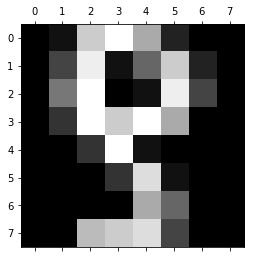

Predicted class: 3	Correct class: 9


<Figure size 432x288 with 0 Axes>

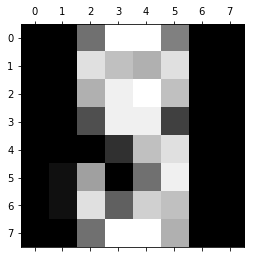

In [6]:
for i in errors.values():
    print("Predicted class: {}\tCorrect class: {}".format(i[0][0], i[0][1]))
    image = []
    for j in range(0, len(i[1]), 8):
        image.append(list(i[1][j:j+8]))
    test.viewDigit(image)

#### 3.1b
From the example below, and from running the code multiple times (generates different training/testing datasets everytime), 5 and 9 are the most confused.<br>
In a way this makes sense because these images are 8x8, so the colors are not always clear. Hence, it is very easy to confuse 5 and 9 with each other or with other numbers.

In [7]:
class Numbers2:
    def __init__(self, trainPercentage):
        digits = sklearn.datasets.load_digits()
    
        self.train_x, self.test_x, self.train_y, self.test_y = \
            train_test_split(digits.data, digits.target, test_size=trainPercentage)

    def classify(self, k):
        """
        Create a classifier using the training data and generate a confusion matrix for the test data
        Return accuracy
        """
        class_digits = KNNClassifier(self.train_x, self.train_y, k)
        confMatrix = class_digits.confusionMatrix(self.test_x, self.test_y)
        accuracy = class_digits.accuracy(confMatrix)
            
        return accuracy
        
    def viewDigit(digitImage):
        """
        Display an image of a digit
        PARAMETERS
        digitImage - a data object from the dataset
        """
        plt.gray()
        plt.matshow(digitImage)
        plt.show()

In [8]:
test = Numbers2(0.2)
x = [i for i in range(1, 1001)]
y = []
for k in range(1, 1001):
    y.append(test.classify(k))

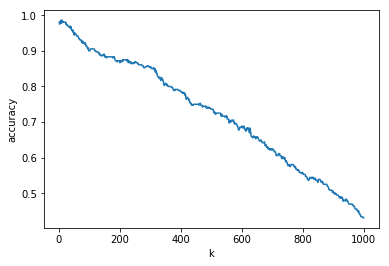

In [9]:
plt.plot(x,y)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

#### 3.2b
From what we see above, in general, increasing k decrease the accuracy. <br>
By testing that for k=1 to k=1000 we see the accuracy decreases from 0.98 to almost 0.5.<br>
It usually depenends on how many classes we have, and in this case we have 10 classes, hence, it makes sense that by increasing k the accuracy will decrease. Because by increasing k we are looking at a bigger range and that is no necessary (k=5 to k=10 it perfect in this case)

In [10]:
x = np.arange(0.05, 1, 0.05)
y = []
for i in x:
    test = Numbers2(i)
    y.append(test.classify(5))

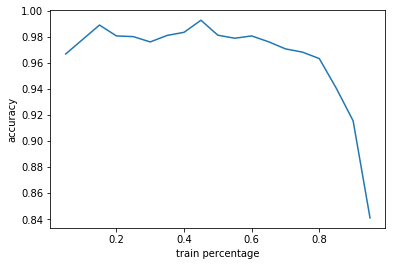

In [11]:
plt.plot(x,y)
plt.xlabel("train percentage")
plt.ylabel("accuracy")
plt.show()

#### 3.3b
From the graph above we see that in general increasing training data percentage decreases the accuracy. However, the impact becomes significant when the train data percantage > 0.5. <br>
When the percentage reaches 0.8, we see that the accuracy starts decreasing drastically.